In [1]:
from IPython.core.debugger import set_trace

### Define lists of datasets, methods and metrics to consider

In [2]:
pwd = !pwd
pwd = pwd[0]

# Absolute path to default Hydra config for normalization script. Take a look at this script to see how normalization is parametrized.
config_path = '/'.join(pwd.split('/')[:-1]) + '/examples/configs/normalization/fit/default.yaml'

# Absolute path to saved train and eval managers. These are results of running `polygrph_eval` on given datasets, and contain UE and metric values we need to produce normalized confidence scores.
EVAL_MAN_PATHS = {
  'CoQA': pwd + '/polygraph_tacl_stablelm12b_coqa.man',
  'GSM8K': pwd + '/polygraph_tacl_stablelm12b_gsm8k.man',
  'MMLU': pwd + '/polygraph_tacl_stablelm12b_mmlu.man',
  'TriviaQA': pwd + '/polygraph_tacl_stablelm12b_triviaqa.man',
  'WMT14': pwd + '/polygraph_tacl_stablelm12b_wmt14.man',
  'WMT19': pwd + '/polygraph_tacl_stablelm12b_wmt19.man',
  'XSum': pwd + '/polygraph_tacl_stablelm12b_xsum.man',
}

# All normalizers require fitting on a held-out set, so we need UE and metric values for train split of datasets that we want to obtain normalized confidence scores for.
TRAIN_MAN_PATHS = {
  'CoQA': pwd + '/polygraph_tacl_stablelm12b_coqa_train.man',
  'GSM8K': pwd + '/polygraph_tacl_stablelm12b_gsm8k_train.man',
  'MMLU': pwd + '/polygraph_tacl_stablelm12b_mmlu_train.man',
  'TriviaQA': pwd + '/polygraph_tacl_stablelm12b_triviaqa_train.man',
  'WMT14': pwd + '/polygraph_tacl_stablelm12b_wmt14_train.man',
  'WMT19': pwd + '/polygraph_tacl_stablelm12b_wmt19_train.man',
  'XSum': pwd + '/polygraph_tacl_stablelm12b_xsum_train.man',
}

# Reuse keys from manager dicts to refer to datasets.
DATASET_NAMES = list(TRAIN_MAN_PATHS.keys())

# List UE methods to normalize and define short names for them to display nicely in tables and charts.
UE_METHOD_NAMES_ABBR = {
    'MaximumSequenceProbability': 'MSP',
    'Perplexity': 'PPL',
    'MeanTokenEntropy': 'MTE',
    'MonteCarloSequenceEntropy': 'MCSE',
    'MonteCarloNormalizedSequenceEntropy': 'MCNSE',
    'MeanPointwiseMutualInformation': 'MPMI',
    'RenyiNeg': 'RenyiNeg',
    'FisherRao': 'FisherRao',
    'TokenSAR': 'TokenSAR',
    'CCP': 'CCP',
    'SemanticEntropy': 'SE',
    'SentenceSAR': 'SentenceSAR',
    'SAR': 'SAR',
    'PTrue': 'PTrue',
    'NumSemSets': 'NumSemSets',
    'EigValLaplacian_NLI_score_entail': 'EVL_entail',
    'EigValLaplacian_NLI_score_contra': 'EVL_contra',
    'EigValLaplacian_Jaccard_score': 'EVL_Jaccard',
    'DegMat_NLI_score_entail': 'DegMat_entail',
    'DegMat_NLI_score_contra': 'DegMat_contra',
    'DegMat_Jaccard_score': 'DegMat_Jaccard',
    'Eccentricity_NLI_score_entail': 'Eccentricity_entail',
    'Eccentricity_NLI_score_contra': 'Eccentricity_contra',
    'Eccentricity_Jaccard_score': 'Eccentricity_Jaccard',
    'LexicalSimilarity_rouge1': 'LS_rouge1',
    'LexicalSimilarity_rouge2': 'LS_rouge2',
    'LexicalSimilarity_rougeL': 'LS_rougeL',
}

# Original names in a list for convenience.
UE_METHOD_NAMES = list(UE_METHOD_NAMES_ABBR.keys())

# A quality metric for model's outputs that is naturally bounded on [0, 1]
GEN_METRIC_NAMES = ['AlignScore']

### Fit normalizers

In [3]:
# Download all managers to current directory
!wget -r --cut-dirs=2 -nH --no-parent -A '*man' http://209.38.249.180:8000/polygraph_data/mans/

--2024-11-29 17:49:46--  http://209.38.249.180:8000/polygraph_data/mans/
Connecting to 209.38.249.180:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4500 (4.4K) [text/html]
Saving to: ‘index.html.tmp’

index.html.tmp      100%[===================>]   4.39K  7.72KB/s    in 0.6s    

2024-11-29 17:49:48 (7.72 KB/s) - ‘index.html.tmp’ saved [4500/4500]

Loading robots.txt; please ignore errors.
--2024-11-29 17:49:48--  http://209.38.249.180:8000/robots.txt
Connecting to 209.38.249.180:8000... connected.
HTTP request sent, awaiting response... 404 File not found
2024-11-29 17:49:49 ERROR 404: File not found.

Removing index.html.tmp since it should be rejected.

--2024-11-29 17:49:49--  http://209.38.249.180:8000/polygraph_data/mans/polygraph_tacl_mistral7b_coqa.man
Connecting to 209.38.249.180:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5449156 (5.2M) [application/x-troff-man]
Saving to: ‘polygraph_tacl_mistral7b_coqa.man’

polygrap

In [4]:
def format_man_paths_list(man_paths):
    """ Formats a list of paths so it can be passed as a parameter override to hydra script call"""
    paths = ['"' + path + '"' for path in man_paths]
    paths = '\'[' + ','.join(paths) + ']\''

    return paths

In [5]:
import os

# Run polygraph_normalize to fit all normalizers using all train datasets.
# Format paths to managers so that Hydra correctly regognizes it as override with list of paths.
train_man_paths = format_man_paths_list(list(TRAIN_MAN_PATHS.values()))
os.system(f'HYDRA_CONFIG={config_path} polygraph_normalize save_path="./" man_paths={train_man_paths}')

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


[2024-11-29 17:51:41,981][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:51:41,981][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:51:41,981][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:51:41,981][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x342b8b1c0>]
[2024-11-29 17:51:41,981][lm_polygraph][INFO] - Done intitializing stat calculators...
[2024-11-29 17:51:42,015][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:51:42,015][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:51:42,015][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:51:42,015][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculat

0

### Normalize UE from test sets

In [6]:
import pickle
import pprint

# Load saved fitted normalizers. These are produced by a successful call to `polygraph_normalize`. We overrided `save_path` to current dir, so the output is saved here.
with open('fitted_normalizers.pickle', 'rb') as f:
    fitted_normalizers = pickle.load(f)

# Normalizers are saved as a pickled dict with tuples of format (metric_name, ue_method_name, normalizer_type). Values are serialized instances of a corresponding normalizer.
pprint.pp(list(fitted_normalizers.keys()))

[('AlignScore', 'MaximumSequenceProbability', 'min_max'),
 ('AlignScore', 'MaximumSequenceProbability', 'quantile'),
 ('AlignScore', 'MaximumSequenceProbability', 'binned_pcc'),
 ('AlignScore', 'MaximumSequenceProbability', 'isotonic_pcc'),
 ('AlignScore', 'Perplexity', 'min_max'),
 ('AlignScore', 'Perplexity', 'quantile'),
 ('AlignScore', 'Perplexity', 'binned_pcc'),
 ('AlignScore', 'Perplexity', 'isotonic_pcc'),
 ('AlignScore', 'MeanTokenEntropy', 'min_max'),
 ('AlignScore', 'MeanTokenEntropy', 'quantile'),
 ('AlignScore', 'MeanTokenEntropy', 'binned_pcc'),
 ('AlignScore', 'MeanTokenEntropy', 'isotonic_pcc'),
 ('AlignScore', 'MeanPointwiseMutualInformation', 'min_max'),
 ('AlignScore', 'MeanPointwiseMutualInformation', 'quantile'),
 ('AlignScore', 'MeanPointwiseMutualInformation', 'binned_pcc'),
 ('AlignScore', 'MeanPointwiseMutualInformation', 'isotonic_pcc'),
 ('AlignScore', 'MeanConditionalPointwiseMutualInformation', 'min_max'),
 ('AlignScore', 'MeanConditionalPointwiseMutualInfo

In [7]:
import numpy as np
from collections import defaultdict
from lm_polygraph.normalizers.minmax import MinMaxNormalizer
from lm_polygraph.normalizers.quantile import QuantileNormalizer
from lm_polygraph.normalizers.binned_pcc import BinnedPCCNormalizer
from lm_polygraph.normalizers.isotonic_pcc import IsotonicPCCNormalizer

# map keys in the pickled normalizers archive to actual normalizer classes.
NORMALIZERS = {
    'min_max': MinMaxNormalizer,
    'quantile': QuantileNormalizer,
    'binned_pcc': BinnedPCCNormalizer,
    'isotonic_pcc': IsotonicPCCNormalizer
}

/opt/homebrew/Caskroom/miniconda/base/envs/ue_abssum/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from lm_polygraph.utils.normalize import get_mans_ues_metrics

# This function loads managers evaluated on test data, extracts raw uncertainty scores and metric scores, and concatenates them
# UE values are returned as a dict with keys corresponding to method names. Metrics have the same format, but keys are metric names. Values are lists of UE or metric scores for all datasets, concatted.
ues, gen_metrics = get_mans_ues_metrics(EVAL_MAN_PATHS.values(), UE_METHOD_NAMES, GEN_METRIC_NAMES)

print(len(ues['MaximumSequenceProbability']))
print(len(gen_metrics['AlignScore']))

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


17019
17019


In [9]:
# Now, let's use normalizers that we loaded earlier to convert raw UE values from test data to bounded confidence scores.
# Output of this function is a nested dict with levels corresponding to type of normalizer, UE method that produced raw UE values, and metric name that was used to calibrate confidence (only for PCC normalizers).
def get_confidences(normalizers, ues):
    """ For each combination of method, gen metric and normalizer type
    load normalizer from encoded string and use it to transform UE array """
    
    confidences = {'min_max': defaultdict(dict),
                   'quantile': defaultdict(dict),
                   'binned_pcc': defaultdict(dict),
                   'isotonic_pcc': defaultdict(dict)}
    
    for key in confidences.keys():
        for method_name in UE_METHOD_NAMES:
            for metric_name in GEN_METRIC_NAMES:
                normalizer = NORMALIZERS[key].loads(normalizers[(metric_name, method_name, key)])
                normalized = normalizer.transform(ues[method_name])
                confidences[key][metric_name][method_name] = normalized

    return confidences

confidences = get_confidences(fitted_normalizers, ues)

### Assess calibratedness of confidence scores

In [10]:
# Good confidence score should be representative of the expected quality of the output. We can measure how good our normalized confidences are by comparing them to AlignScores of corresponding outputs in terms of Mean Squared error.
def calculate_mses(confidences, gen_metrics, ues):
    """ Given a list of confidences and gen metrics calculates MSE between them
    for each combination of method, metric and normalizer type"""
    
    mses = {'min_max': defaultdict(dict),
            'quantile': defaultdict(dict),
            'binned_pcc': defaultdict(dict),
            'isotonic_pcc': defaultdict(dict)}
    
    for key in confidences.keys():
        for metric_name in GEN_METRIC_NAMES:
            metric_mses = []
            for method_name in UE_METHOD_NAMES:
                gt_metric = gen_metrics[metric_name]
                mse = ((confidences[key][metric_name][method_name] - gt_metric) ** 2).mean()
                metric_mses.append(mse)
            mses[key][metric_name] = metric_mses

    return mses

mses = calculate_mses(confidences, gen_metrics, ues)

In [11]:
def plot_mses(ax, mses, title):
    ax.bar(x-0.3, mses['min_max']['AlignScore'], width=0.2, color='g', align='center', label='Linear')
    ax.bar(x-0.1, mses['quantile']['AlignScore'], width=0.2, color='b', align='center', label='Quantile')
    ax.bar(x+0.1, mses['binned_pcc']['AlignScore'], width=0.2, color='tab:olive', align='center', label='Binned')
    ax.bar(x+0.3, mses['isotonic_pcc']['AlignScore'], width=0.2, color='r', align='center', label='Isotonic')

    ax.set_xticks(range(len(UE_METHOD_NAMES)), list(UE_METHOD_NAMES_ABBR.values()), rotation=90, fontsize=14)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel('MSE', fontsize=18)

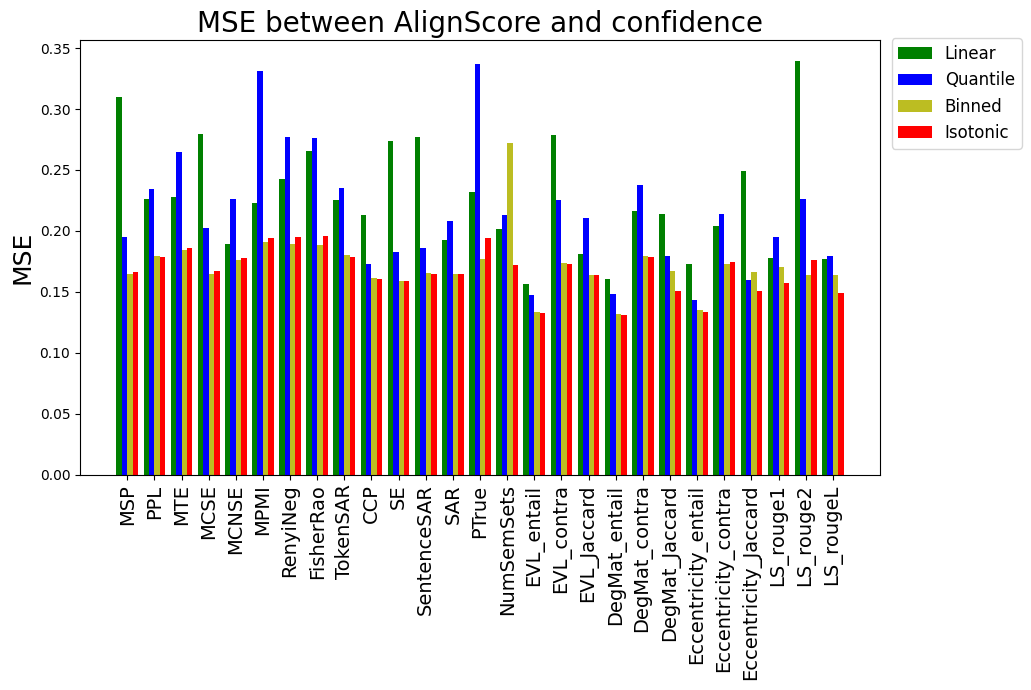

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

x = np.array(list(range(len(UE_METHOD_NAMES))))

f, ax = plt.subplots(1, 1, figsize=(9, 7))

plot_mses(ax, mses, 'MSE between AlignScore and confidence')

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, bbox_to_anchor=(1.15, 0.95), fontsize=12)

plt.tight_layout()
#plt.savefig(f'normalization_mse_total.pdf', bbox_inches='tight')
plt.show()
plt.clf()

This chart shows that explicitely calibrated methods (Binned and Isotonic PCC) prove to be much better predictors of output quality.

### OOD Datasets

Now, let's assess how this performance holds up when we evaluate normalizers on data that differers from the data they were fitted on.

In [15]:
ood_confidences = {}
ood_mses = {}

for dataset_name in DATASET_NAMES:
    # Fit normalizers excluding current OOD dataset from train set
    train_man_paths_wo_dataset = [value for key, value in TRAIN_MAN_PATHS.items() if key != dataset_name]
    train_man_paths_wo_dataset = format_man_paths_list(train_man_paths_wo_dataset)
    os.system(f'HYDRA_CONFIG={config_path} polygraph_normalize save_path="./ood_{dataset_name}" man_paths={train_man_paths_wo_dataset}')

    # Get UE and metric values for OOD dataset
    ood_ues, ood_gen_metrics = get_mans_ues_metrics([EVAL_MAN_PATHS[dataset_name]], UE_METHOD_NAMES, GEN_METRIC_NAMES)

    with open(f'./ood_{dataset_name}/fitted_normalizers.json', 'rb') as f:
        fitted_normalizers = pickle.load(f)

    ood_confidences[dataset_name] = get_confidences(fitted_normalizers, ood_ues)
    ood_mses[dataset_name] = calculate_mses(ood_confidences[dataset_name], ood_gen_metrics, ood_ues)

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


[2024-11-29 17:53:44,300][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:53:44,300][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:53:44,300][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:53:44,300][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x31e4cf820>]
[2024-11-29 17:53:44,300][lm_polygraph][INFO] - Done intitializing stat calculators...
[2024-11-29 17:53:44,313][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:53:44,313][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:53:44,313][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:53:44,313][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculat

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)
/Users/roma

[2024-11-29 17:53:50,498][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:53:50,498][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:53:50,498][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:53:50,498][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x3465cfa30>]
[2024-11-29 17:53:50,498][lm_polygraph][INFO] - Done intitializing stat calculators...
[2024-11-29 17:53:50,509][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:53:50,509][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:53:50,509][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:53:50,509][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculat

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)
/Users/roma

[2024-11-29 17:53:56,857][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:53:56,857][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:53:56,858][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:53:56,858][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x346bcfa00>]
[2024-11-29 17:53:56,858][lm_polygraph][INFO] - Done intitializing stat calculators...
[2024-11-29 17:53:56,896][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:53:56,897][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:53:56,897][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:53:56,897][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculat

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)
/Users/roma

[2024-11-29 17:54:03,529][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:54:03,529][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:54:03,530][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:54:03,530][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x3242d3610>]
[2024-11-29 17:54:03,530][lm_polygraph][INFO] - Done intitializing stat calculators...
[2024-11-29 17:54:03,568][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:54:03,568][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:54:03,568][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:54:03,568][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculat

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)
/Users/roma

[2024-11-29 17:54:09,558][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:54:09,558][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:54:09,558][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:54:09,558][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x3469cf940>]
[2024-11-29 17:54:09,559][lm_polygraph][INFO] - Done intitializing stat calculators...
[2024-11-29 17:54:09,593][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:54:09,593][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:54:09,593][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:54:09,593][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculat

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)
/Users/roma

[2024-11-29 17:54:15,605][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:54:15,605][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:54:15,606][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:54:15,606][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x345ccf9d0>]
[2024-11-29 17:54:15,606][lm_polygraph][INFO] - Done intitializing stat calculators...
[2024-11-29 17:54:15,640][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:54:15,640][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:54:15,641][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:54:15,641][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculat

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)
/Users/roma

[2024-11-29 17:54:21,631][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:54:21,631][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:54:21,631][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:54:21,631][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x3265d3d30>]
[2024-11-29 17:54:21,631][lm_polygraph][INFO] - Done intitializing stat calculators...
[2024-11-29 17:54:21,667][lm_polygraph][INFO] - ====================================================================================================
[2024-11-29 17:54:21,667][lm_polygraph][INFO] - Initializing stat calculators...
[2024-11-29 17:54:21,668][lm_polygraph][INFO] - Initializing GreedyProbsCalculator
[2024-11-29 17:54:21,668][lm_polygraph][INFO] - Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculat

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


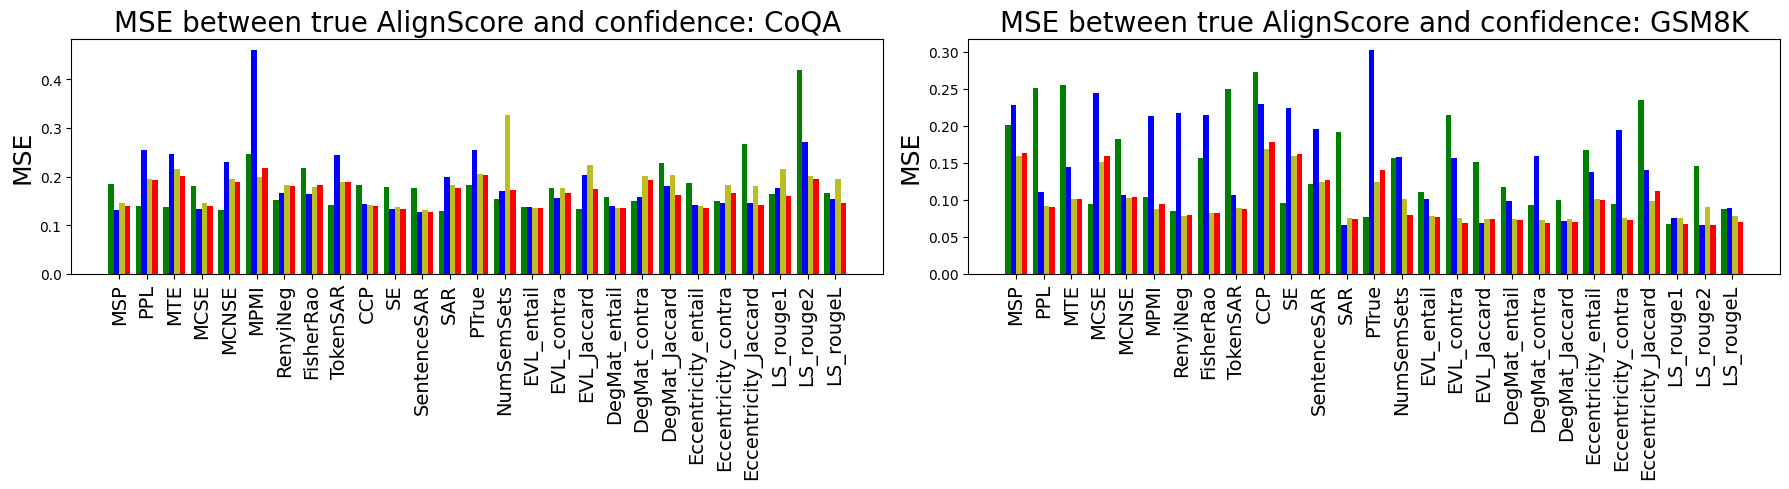

<Figure size 640x480 with 0 Axes>

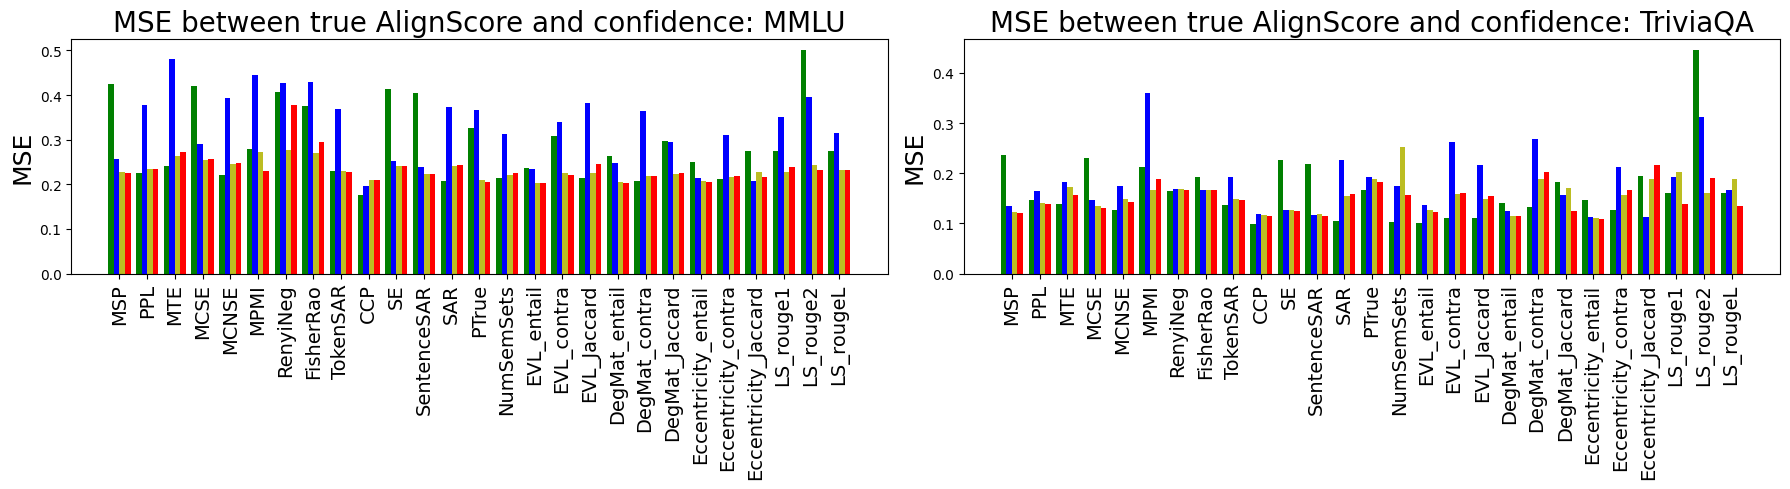

<Figure size 640x480 with 0 Axes>

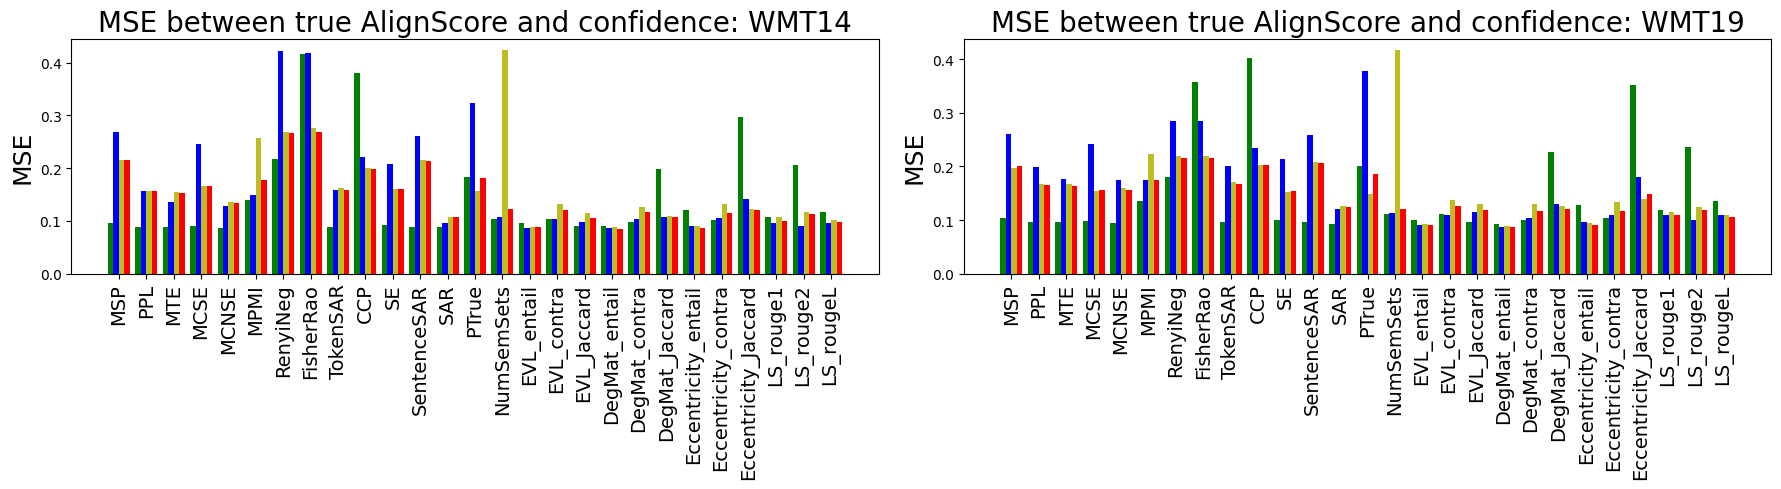

<Figure size 640x480 with 0 Axes>

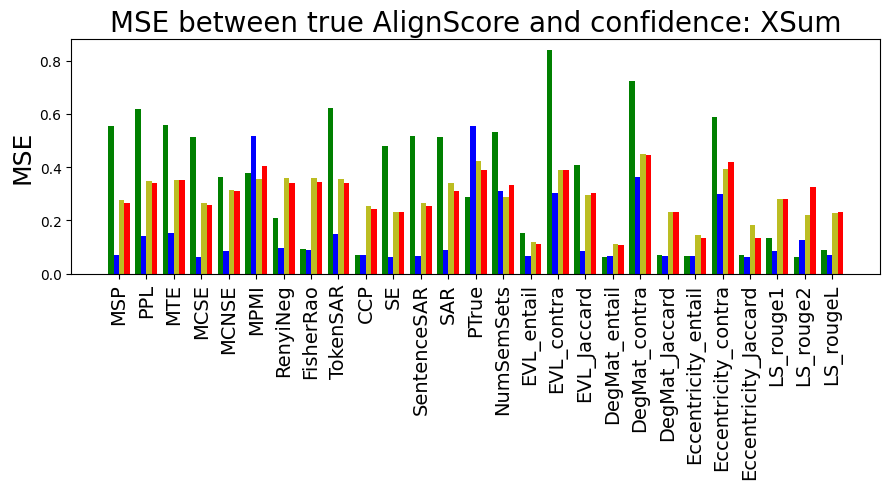

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Some fuckery to make charts easier to align in the paper.
is_even = (len(DATASET_NAMES) % 2 == 0)
even_datasets_subset = DATASET_NAMES if is_even else DATASET_NAMES[:-1]
dataset_pairs = [even_datasets_subset[i:i + 2] for i in range(0, len(even_datasets_subset), 2)]

x = np.array(list(range(len(UE_METHOD_NAMES))))

for dataset_pair in dataset_pairs:
    fig = plt.figure(figsize=(18, 5))
    gs = GridSpec(1, 2, figure=fig)

    for i, dataset_name in enumerate(dataset_pair):
        ax = fig.add_subplot(gs[i//2,i%2])
        plot_mses(ax, ood_mses[dataset_name], f'MSE between true AlignScore and confidence: {dataset_name}')
        handles, labels = ax.get_legend_handles_labels()
    
    plt.tight_layout()
    #plt.savefig(f'normalization_mse_ood_{"_".join(dataset_pair).lower()}.pdf')
    plt.show()
    plt.clf()

if not is_even:
    dataset_name = DATASET_NAMES[-1]
    
    fig = plt.figure(figsize=(9, 5))
    gs = GridSpec(1, 1, figure=fig)

    ax = fig.add_subplot(gs[0,0])

    plot_mses(ax, ood_mses[dataset_name], f'MSE between true AlignScore and confidence: {dataset_name}')
    
    plt.tight_layout()
    #plt.savefig(f'normalization_mse_ood_{dataset_name.lower()}.pdf')
    plt.show()
    plt.clf()

### PRR change relative to raw uncertainty

We want bounded confidence scores to induce the same ordering of the data, as underlying raw uncertainty. Let's check how much normalization affects PRR - a metric that is sensitive to this ordering.

In [17]:
from lm_polygraph.utils.normalize import filter_nans
from lm_polygraph.ue_metrics.pred_rej_area import PredictionRejectionArea
from lm_polygraph.ue_metrics.ue_metric import (
    get_random_scores,
    normalize_metric,
)
import pandas as pd

ue_metric = PredictionRejectionArea()

cols = ['MinMax', 'Quantile', 'Binned PCC', 'Isotonic PCC']

# For each of the dataset we take all confidences calculated in OOD setting
# and compare PRR of this to raw unnormalized UE
for dataset_name, path in EVAL_MAN_PATHS.items():
    res = {}
    all_ues, all_gen_metrics = get_mans_ues_metrics([path], UE_METHOD_NAMES, GEN_METRIC_NAMES)
    train_man_paths_wo_dataset = [value for key, value in TRAIN_MAN_PATHS.items() if key != dataset_name]
    train_ues, train_gen_metrics = get_mans_ues_metrics(train_man_paths_wo_dataset, UE_METHOD_NAMES, GEN_METRIC_NAMES)

    for metric_name in GEN_METRIC_NAMES:
        gen_metrics = all_gen_metrics[metric_name]
        for ue_method_name in UE_METHOD_NAMES:
            ues = all_ues[ue_method_name]
            
            filtered_metric, filtered_ues = filter_nans(gen_metrics, ues)
            
            # -np.array() because we want to convert confidence scores to uncertainty scores for use in the function that calculates PRR
            minmax_ues = -np.array(ood_confidences[dataset_name]['min_max'][metric_name][ue_method_name])
            quantile_ues = -np.array(ood_confidences[dataset_name]['quantile'][metric_name][ue_method_name])
            binned_pcc_ues = -np.array(ood_confidences[dataset_name]['binned_pcc'][metric_name][ue_method_name])
            isotonic_pcc_ues = -np.array(ood_confidences[dataset_name]['isotonic_pcc'][metric_name][ue_method_name])

            # ideal UE for a given metric, is a negated metric itself, because it orders data in the order of strictly increasing quality.
            oracle_score = ue_metric(-filtered_metric, filtered_metric)
            random_score = get_random_scores(ue_metric, filtered_metric)

            raw_ue_metric_val = ue_metric(filtered_ues, filtered_metric)
            # Normalize here refers to normalization of PRR metric using random and oracle UEs.
            raw_score = normalize_metric(raw_ue_metric_val, oracle_score, random_score)

            minmax_ue_metric_val = ue_metric(minmax_ues, filtered_metric)
            minmax_score = normalize_metric(minmax_ue_metric_val, oracle_score, random_score)
            minmax_diff = raw_score - minmax_score

            quantile_ue_metric_val = ue_metric(quantile_ues, filtered_metric)
            quantile_score = normalize_metric(quantile_ue_metric_val, oracle_score, random_score)
            quantile_diff = raw_score - quantile_score
            
            binned_pcc_ue_metric_val = ue_metric(binned_pcc_ues, filtered_metric)
            binned_pcc_score = normalize_metric(binned_pcc_ue_metric_val, oracle_score, random_score)
            binned_pcc_diff = raw_score - binned_pcc_score

            isotonic_pcc_ue_metric_val = ue_metric(isotonic_pcc_ues, filtered_metric)
            isotonic_pcc_score = normalize_metric(isotonic_pcc_ue_metric_val, oracle_score, random_score)
            isotonic_pcc_diff = raw_score - isotonic_pcc_score

            res[ue_method_name] = [minmax_diff, quantile_diff, binned_pcc_diff, isotonic_pcc_diff]

    # Show table for each datasets that contains difference between raw UE PRR and PRR based on normalized confidence
    # Lower is better, negative is best (means normalized confidence improves upon raw PRR
    df = pd.DataFrame.from_dict(res, orient='index', columns=cols)
    display(df)

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


,MinMax,Quantile,Binned PCC,Isotonic PCC
MaximumSequenceProbability,0.000000,3.027419e-05,0.045624,0.000520
Perplexity,0.000054,6.973301e-05,0.017120,0.001801
MeanTokenEntropy,0.000000,8.562246e-05,0.071875,0.000000
MonteCarloSequenceEntropy,0.000000,6.969507e-05,0.072111,0.003679
MonteCarloNormalizedSequenceEntropy,0.000043,7.251505e-06,0.026097,0.004289
MeanPointwiseMutualInformation,0.000000,-1.521409e-05,0.023563,0.000000
RenyiNeg,0.000000,-2.396752e-04,0.001152,0.000000
FisherRao,0.000000,-2.710695e-04,-0.032335,0.000000
TokenSAR,0.000000,-1.308053e-05,0.027570,0.000000
CCP,0.000000,6.074188e-05,0.053289,0.000000


/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


,MinMax,Quantile,Binned PCC,Isotonic PCC
MaximumSequenceProbability,0.000000,0.000022,-0.014490,0.000000e+00
Perplexity,0.000000,0.000035,0.077725,0.000000e+00
MeanTokenEntropy,0.000000,0.000088,0.051275,0.000000e+00
MonteCarloSequenceEntropy,0.000199,0.000205,0.100969,4.264822e-02
MonteCarloNormalizedSequenceEntropy,0.000000,-0.000130,0.026921,0.000000e+00
MeanPointwiseMutualInformation,0.000000,0.000218,0.372224,0.000000e+00
RenyiNeg,0.000000,-0.000260,-0.157606,0.000000e+00
FisherRao,0.000000,-0.000083,-0.073898,-6.717210e-03
TokenSAR,0.000000,0.000009,0.079779,0.000000e+00
CCP,0.000000,-0.000027,0.012593,0.000000e+00


/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


,MinMax,Quantile,Binned PCC,Isotonic PCC
MaximumSequenceProbability,0.000000,2.871689e-05,0.034351,0.000000e+00
Perplexity,0.000000,-7.757970e-06,0.076598,0.000000e+00
MeanTokenEntropy,0.000000,4.218778e-05,-0.078761,0.000000e+00
MonteCarloSequenceEntropy,0.000000,1.287856e-05,0.018792,0.000000e+00
MonteCarloNormalizedSequenceEntropy,0.000000,6.304778e-07,0.071458,0.000000e+00
MeanPointwiseMutualInformation,0.000000,2.981897e-05,0.171447,2.737807e-04
RenyiNeg,0.042275,2.259064e-02,0.383408,3.057858e-01
FisherRao,0.054812,4.174128e-02,0.364305,2.874385e-01
TokenSAR,0.000000,-1.901745e-05,0.137471,0.000000e+00
CCP,0.000000,3.640882e-04,-0.003296,0.000000e+00


/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


,MinMax,Quantile,Binned PCC,Isotonic PCC
MaximumSequenceProbability,-1.436972e-05,0.000125,0.076625,-0.000178
Perplexity,0.000000e+00,-0.000021,0.032847,0.000105
MeanTokenEntropy,0.000000e+00,-0.000025,0.210053,-0.000190
MonteCarloSequenceEntropy,-1.436972e-05,-0.000104,0.068503,0.001713
MonteCarloNormalizedSequenceEntropy,0.000000e+00,-0.000067,0.040447,-0.000077
MeanPointwiseMutualInformation,0.000000e+00,0.000046,-0.102983,0.000000
RenyiNeg,0.000000e+00,0.000406,0.039837,0.000000
FisherRao,0.000000e+00,-0.000056,0.018743,0.000000
TokenSAR,0.000000e+00,0.000081,0.034179,0.000107
CCP,0.000000e+00,0.000351,0.104994,0.000000


/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


,MinMax,Quantile,Binned PCC,Isotonic PCC
MaximumSequenceProbability,0.000000,-0.000010,0.146019,0.000000e+00
Perplexity,0.000000,-0.000024,0.023779,0.000000e+00
MeanTokenEntropy,0.000000,0.000081,0.040141,0.000000e+00
MonteCarloSequenceEntropy,0.000000,-0.000028,0.202491,0.000000e+00
MonteCarloNormalizedSequenceEntropy,0.000000,-0.000291,-0.028530,0.000000e+00
MeanPointwiseMutualInformation,0.000000,0.000014,0.015287,0.000000e+00
RenyiNeg,0.000000,0.000080,-0.036264,0.000000e+00
FisherRao,0.000000,-0.000045,-0.033429,0.000000e+00
TokenSAR,0.000000,0.000030,0.056822,0.000000e+00
CCP,0.000000,-0.000071,0.018330,1.180986e-03


/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


,MinMax,Quantile,Binned PCC,Isotonic PCC
MaximumSequenceProbability,0.000000,-0.000154,0.093635,0.000000
Perplexity,0.000000,0.000233,0.004554,0.000000
MeanTokenEntropy,0.000000,-0.000198,0.016244,0.000000
MonteCarloSequenceEntropy,0.000000,0.000113,0.233209,0.000000
MonteCarloNormalizedSequenceEntropy,0.000000,0.000165,-0.015257,0.000000
MeanPointwiseMutualInformation,0.000000,0.000140,-0.067971,0.000000
RenyiNeg,0.000000,-0.000028,-0.032297,0.000000
FisherRao,0.000000,0.000075,-0.017059,0.000000
TokenSAR,0.000000,-0.000368,0.036396,0.000000
CCP,0.000000,-0.000017,-0.009927,0.000000


/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


,MinMax,Quantile,Binned PCC,Isotonic PCC
MaximumSequenceProbability,0.0,0.000124,-0.021840,0.000000e+00
Perplexity,0.0,-0.000001,0.011166,2.583817e-03
MeanTokenEntropy,0.0,0.000081,0.019600,1.292801e-04
MonteCarloSequenceEntropy,0.0,0.000055,-0.014168,0.000000e+00
MonteCarloNormalizedSequenceEntropy,0.0,-0.000012,-0.000438,2.623113e-03
MeanPointwiseMutualInformation,0.0,0.000111,0.045119,0.000000e+00
RenyiNeg,0.0,-0.000023,-0.014453,9.751362e-07
FisherRao,0.0,0.000012,-0.026447,0.000000e+00
TokenSAR,0.0,0.000037,-0.002302,1.350922e-03
CCP,0.0,-0.000040,-0.003910,0.000000e+00


In [18]:
all_ues, all_gen_metrics = get_mans_ues_metrics(list(EVAL_MAN_PATHS.values()), UE_METHOD_NAMES, GEN_METRIC_NAMES)

# Same for all datasets concatenated
for metric_name in GEN_METRIC_NAMES:
    gen_metrics = all_gen_metrics[metric_name]
    for ue_method_name in UE_METHOD_NAMES:
        ues = all_ues[ue_method_name]

        filtered_metric, filtered_ues = filter_nans(gen_metrics, ues)

        minmax_ues = -np.array(confidences['min_max'][metric_name][ue_method_name])
        quantile_ues = -np.array(confidences['quantile'][metric_name][ue_method_name])
        binned_pcc_ues = -np.array(confidences['binned_pcc'][metric_name][ue_method_name])
        isotonic_pcc_ues = -np.array(confidences['isotonic_pcc'][metric_name][ue_method_name])

        oracle_score = ue_metric(-filtered_metric, filtered_metric)
        random_score = get_random_scores(ue_metric, filtered_metric)

        raw_ue_metric_val = ue_metric(filtered_ues, filtered_metric)
        raw_score = normalize_metric(raw_ue_metric_val, oracle_score, random_score)

        minmax_ue_metric_val = ue_metric(minmax_ues, filtered_metric)
        minmax_score = normalize_metric(minmax_ue_metric_val, oracle_score, random_score)
        minmax_diff = raw_score - minmax_score

        quantile_ue_metric_val = ue_metric(quantile_ues, filtered_metric)
        quantile_score = normalize_metric(quantile_ue_metric_val, oracle_score, random_score)
        quantile_diff = raw_score - quantile_score

        binned_pcc_ue_metric_val = ue_metric(binned_pcc_ues, filtered_metric)
        binned_pcc_score = normalize_metric(binned_pcc_ue_metric_val, oracle_score, random_score)
        binned_pcc_diff = raw_score - binned_pcc_score

        isotonic_pcc_ue_metric_val = ue_metric(isotonic_pcc_ues, filtered_metric)
        isotonic_pcc_score = normalize_metric(isotonic_pcc_ue_metric_val, oracle_score, random_score)
        isotonic_pcc_diff = raw_score - isotonic_pcc_score

        res[ue_method_name] = [minmax_diff, quantile_diff, binned_pcc_diff, isotonic_pcc_diff]

df = pd.DataFrame.from_dict(res, orient='index', columns=cols)
display(df)

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:457: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


,MinMax,Quantile,Binned PCC,Isotonic PCC
MaximumSequenceProbability,-5.721821e-06,-0.000007,-0.050397,0.000043
Perplexity,-8.007145e-06,0.000008,0.018182,0.000331
MeanTokenEntropy,3.145503e-10,0.000002,-0.008805,0.000059
MonteCarloSequenceEntropy,-5.044093e-06,-0.000003,-0.068054,0.000486
MonteCarloNormalizedSequenceEntropy,3.145507e-10,-0.000005,0.009059,0.000766
MeanPointwiseMutualInformation,0.000000e+00,0.000069,-0.313686,0.000000
RenyiNeg,0.000000e+00,0.000047,-0.133791,0.000259
FisherRao,0.000000e+00,0.000025,-0.144247,0.000000
TokenSAR,0.000000e+00,0.000003,0.023153,0.000057
CCP,0.000000e+00,0.000169,0.000600,0.000306


### Table coloring and formatting

In [19]:
import matplotlib
from matplotlib import colors

cmap = matplotlib.cm.get_cmap('Greens')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = 0.5
my_cmap = colors.ListedColormap(my_cmap)

def b_g(values, cmap, low=0, high=0):
    # values = s.apply(lambda x: float(x.split("±")[0]) if len(x.split("±"))>1 else x)
    
    rng = values.max().max() - values.min().min()
    norm = colors.Normalize(values.min().min() - (rng * low), values.max().max() + (rng * high))
    normed = norm(values.values)
    back_colors = [[colors.rgb2hex(val) for val in x] for x in plt.cm.get_cmap(cmap)(normed)]
    text_colors = [["white" if val>0.3 else "black" for val in x] for x in normed]
    
    return np.array([[f'color: {text_color}; background-color: {color}' for text_color, color in zip(row_text_colors, row_colors)] for row_text_colors, row_colors in zip(text_colors, back_colors)])

/var/folders/90/h7h5kff91yn2dlhll8j4rxj80000gn/T/ipykernel_82297/2365908746.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Greens')


In [20]:
def rgba2rgb(rgba, background=(1,1,1)):
    ch = rgba.shape[0]
    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    r, g, b, a = rgba[0], rgba[1], rgba[2], rgba[3]
    a = np.asarray(a, dtype='float32')
    R, G, B = background

    r_new = r * a + (1.0 - a) * R
    g_new = g * a + (1.0 - a) * G
    b_new = b * a + (1.0 - a) * B

    return [r_new, g_new, b_new]


def to_color(text, vals):
    vals = rgba2rgb(np.array(vals))
    return '\\cellcolor[rgb]{'+f'{vals[0]},'+f'{vals[1]},'+f'{vals[2]}'+'} '+f'{text}'

def bold_best(df, columns):
    total_min = df.values.min().min()
    total_max = df.values.max().max()
    for col in columns:
        values_init_raw = [x if x!='-' else np.nan for x in df[col]]
        values_init = np.array([x for x in df[col] if x!='-'])
        if values_init.min() != values_init.max():
            values_init_raw = np.array([(x - total_min) / (total_max - total_min) if not np.isnan(x) else x for x in values_init_raw])
            
        def get_new_x(x):
            if isinstance(x, str):
                return x
            return '-'
        
        values = [to_color("{:.3f}".format(raw), my_cmap(float(x))) if (isinstance(x, float) and (not np.isnan(x))) else get_new_x(x) for raw, x in zip(df[col], values_init_raw)]
        df[col] = values
    return df

df = pd.DataFrame.from_dict(res, orient='index', columns=cols)
df.style.apply(b_g, cmap=cmap, axis=None)
df_colored = bold_best(df, df.columns)
with open('total_prr_table.tex', 'w') as f:
    with pd.option_context("max_colwidth", 1000):
        table = df_colored.to_latex()
        table = table.replace('-0.000', '0.000')
        table = table.replace('\\textbackslash ', '\\')
        table = table.replace('\\{', '{')
        table = table.replace('\\}', '}')
        f.write(table)

### Normalized confidence vs raw uncertainty plots

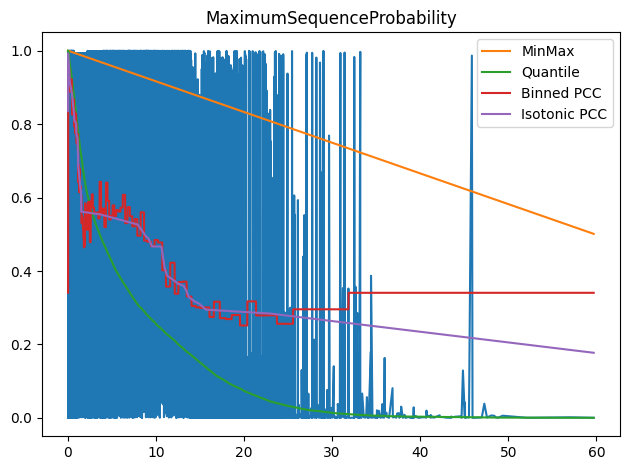

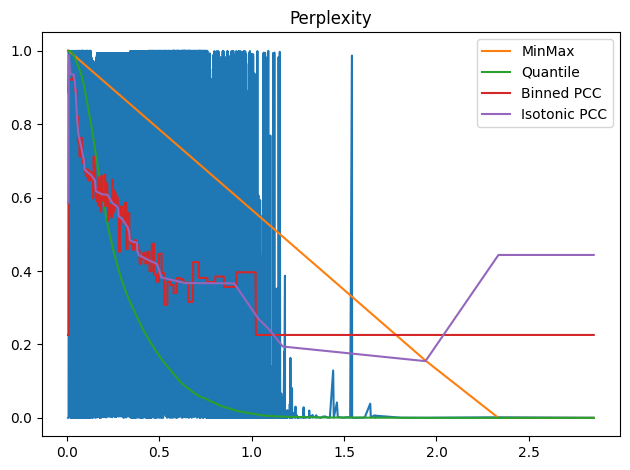

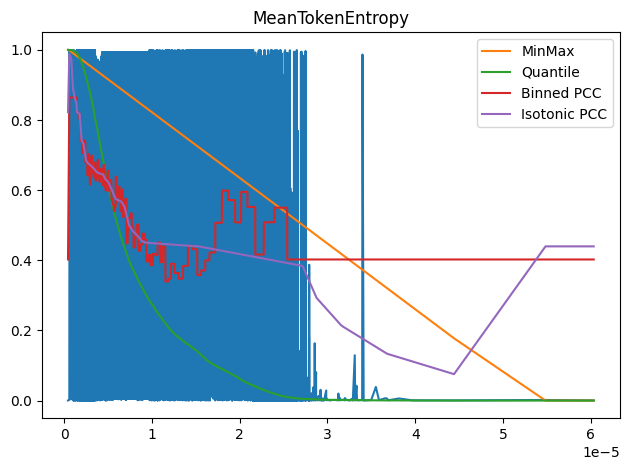

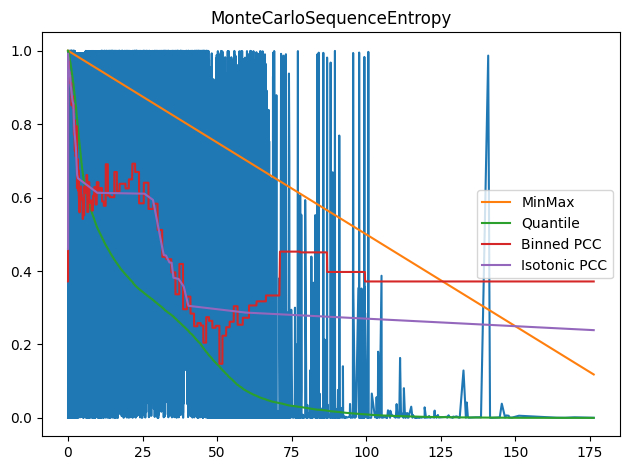

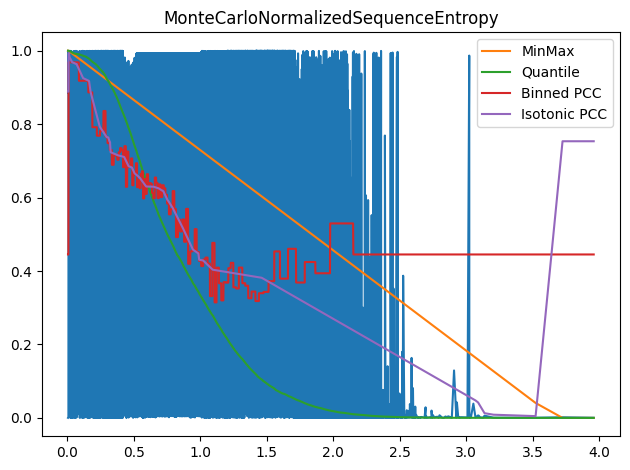

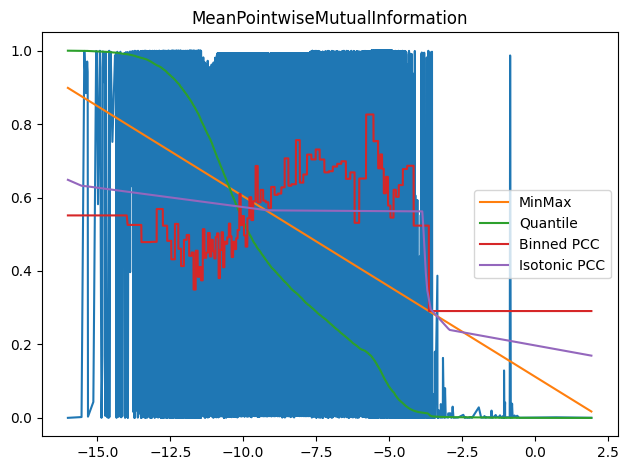

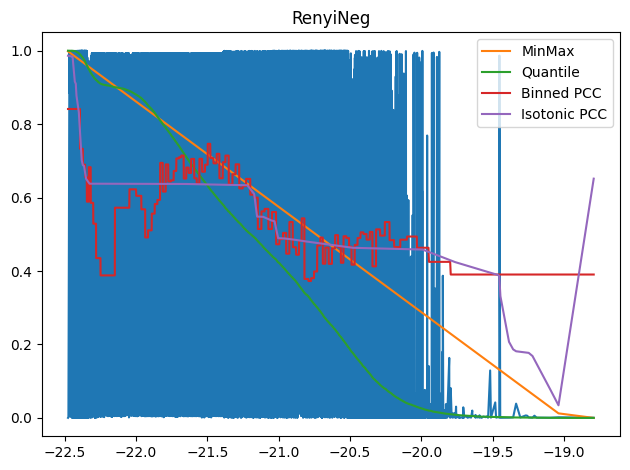

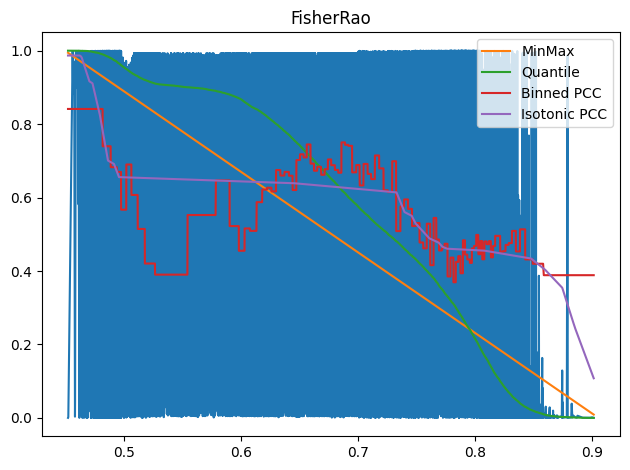

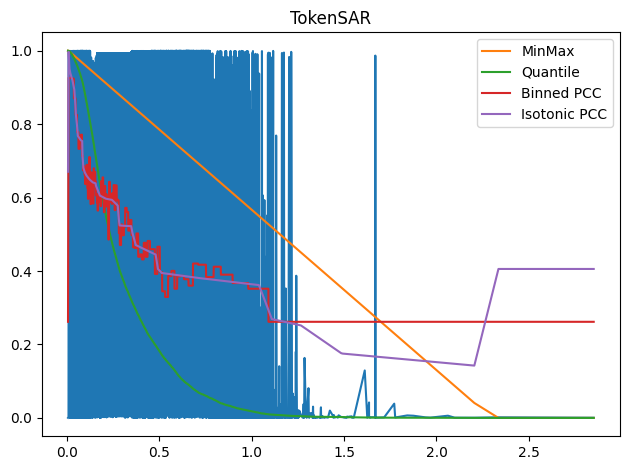

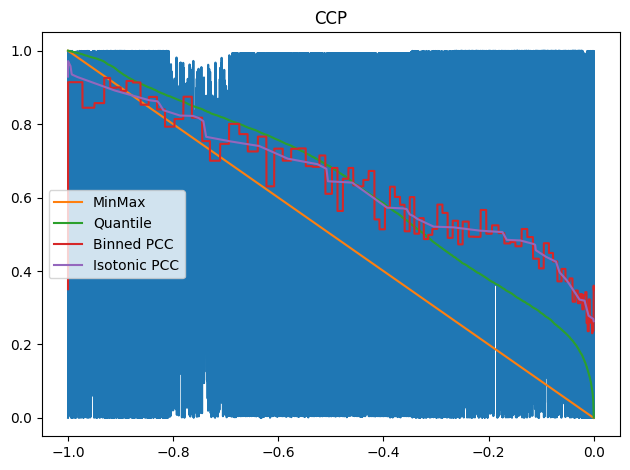

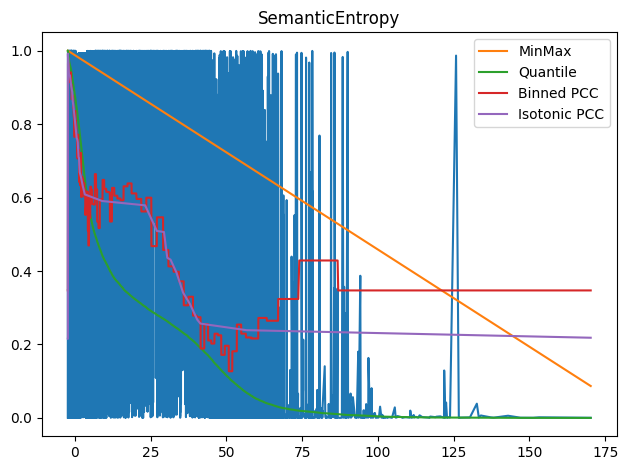

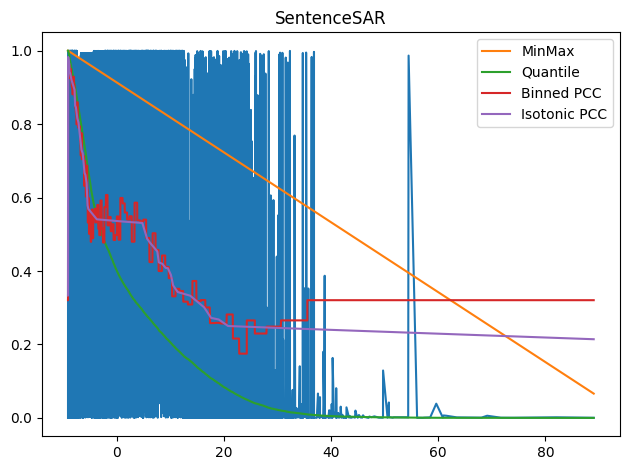

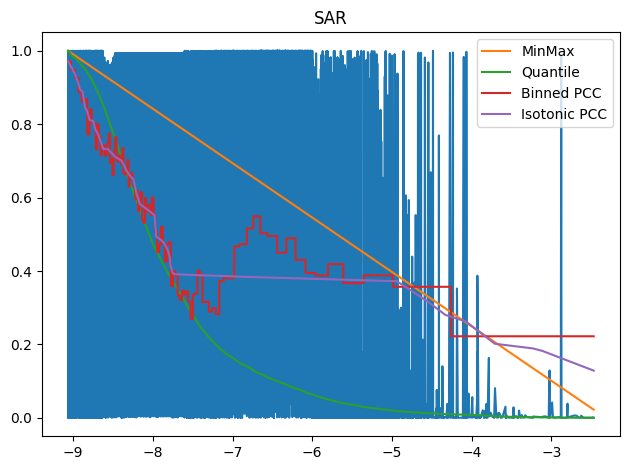

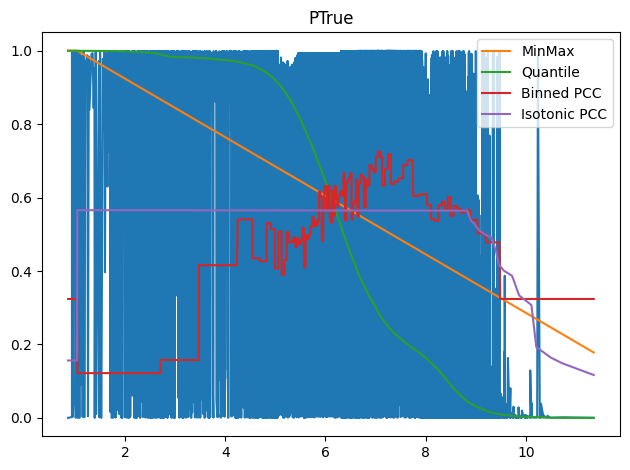

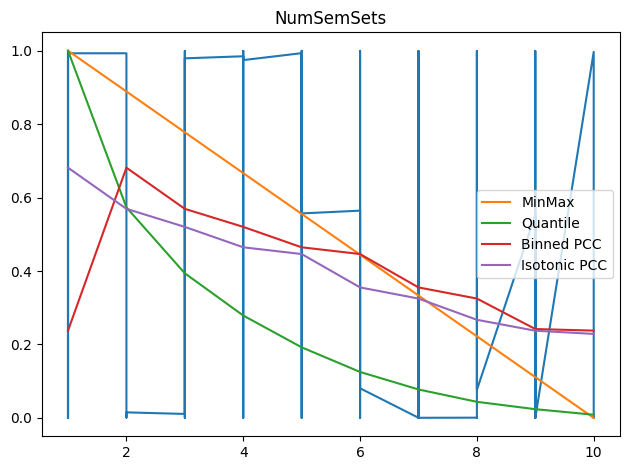

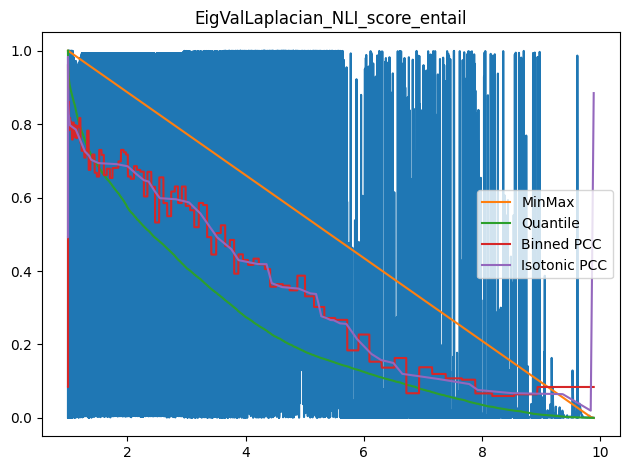

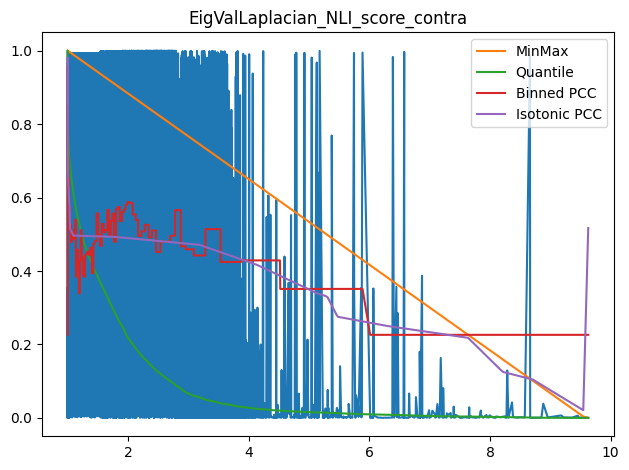

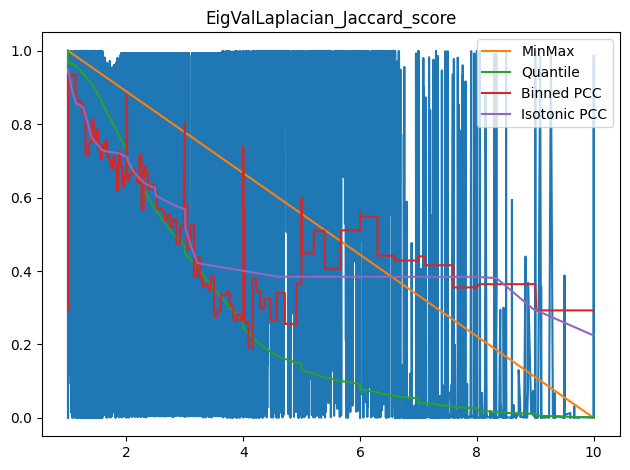

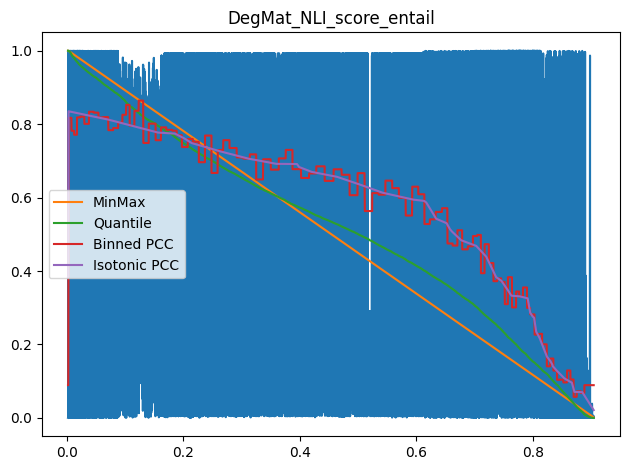

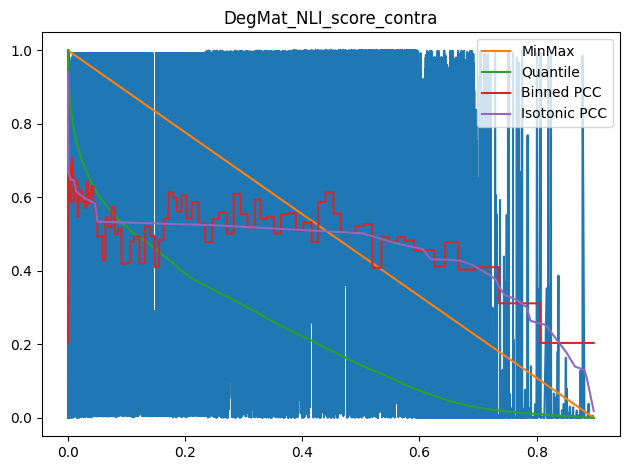

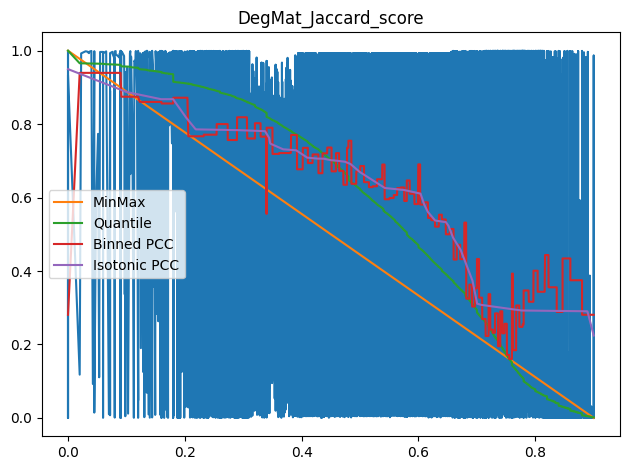

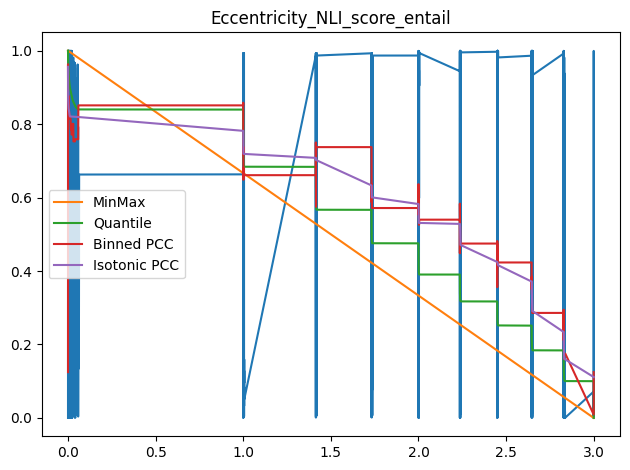

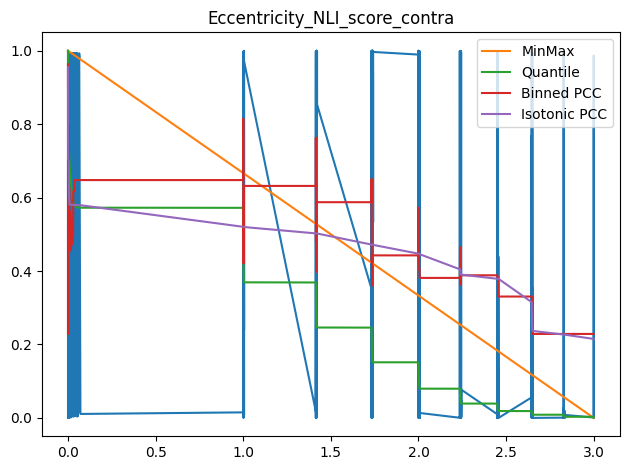

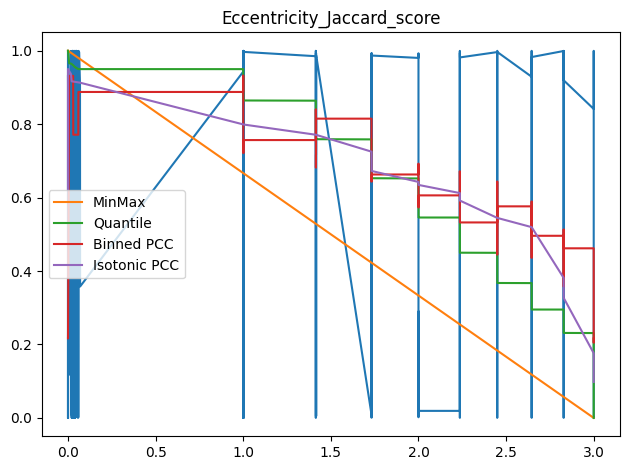

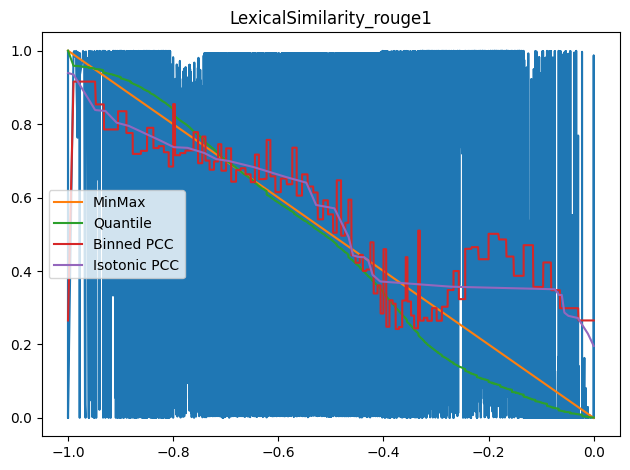

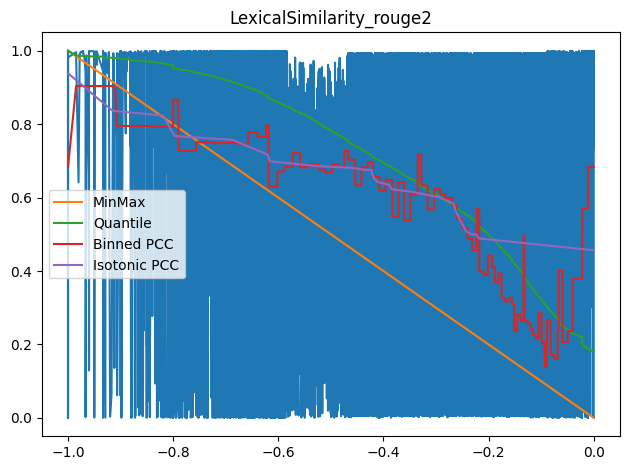

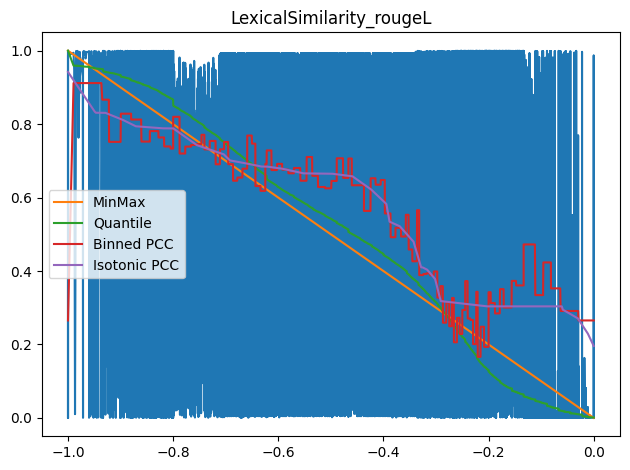

<Figure size 640x480 with 0 Axes>

In [21]:
for method in UE_METHOD_NAMES:
    metric = 'AlignScore'
    cur_ues = all_ues[method]
    order = np.argsort(cur_ues)
    sor_ues = cur_ues[order]
    sor_metrics = all_gen_metrics[metric]
    plt.plot(sor_ues, sor_metrics)
    plt.plot(sor_ues, confidences['min_max'][metric][method][order], label='MinMax')
    plt.plot(sor_ues, confidences['quantile'][metric][method][order], label='Quantile')
    plt.plot(sor_ues, confidences['binned_pcc'][metric][method][order], label='Binned PCC')
    plt.plot(sor_ues, confidences['isotonic_pcc'][metric][method][order], label='Isotonic PCC')
    plt.title(method)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.clf()